In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, truncnorm, dirichlet
import random
import seaborn as sns
import math

## Patient setup

### Prob of Death

Text(0, 0.5, 'Probability of death')

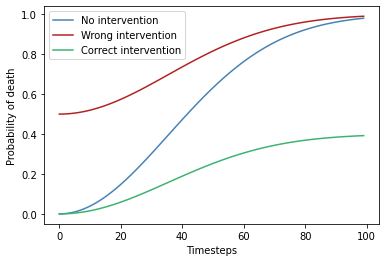

In [201]:
def plot_patient(ax, c=2, scale=50, a=2.5, b=2):
    """Plot patient prob of death with interventions."""
    x = weibull_min(c=c, loc=0, scale=scale)
    ls = []
    right = []
    wrong = []
    for n in range(100):
        ls.append(x.cdf(n))
        right.append(x.cdf(n)/a)
        wrong.append((x.cdf(n)+1)/b)
    ax.plot(ls, label="No intervention", color='steelblue')
    ax.plot(wrong, label="Wrong intervention", color='firebrick')
    ax.plot(right, label="Correct intervention", color='mediumseagreen')


fig, ax = plt.subplots()
plot_patient(ax)
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("Probability of death")

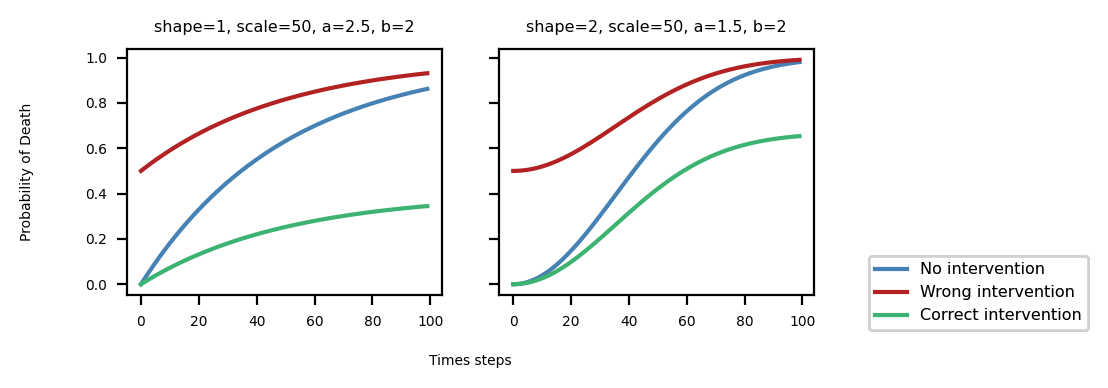

In [244]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True) 
fig.dpi = 200 
fig.tight_layout(pad=1.5) 
fig.set_size_inches(4, 1.5)

plot_patient(axs[0], c=1) 
axs[0].set_title("shape=1, scale=50, a=2.5, b=2", fontsize='xx-small') 
plot_patient(axs[1], a=1.5) 
axs[1].set_title("shape=2, scale=50, a=1.5, b=2", fontsize='xx-small')

for i in range(2): 
    axs[i].tick_params(axis='both', labelsize=5) 
    handles, labels = axs[1].get_legend_handles_labels() 
    fig.legend(handles, labels, fontsize='xx-small', loc='lower right', bbox_to_anchor=(1.3, -0.03))

fig.add_subplot(111, frameon=False) 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) 
plt.xlabel("Times steps", fontsize=5) 
plt.ylabel("Probability of Death", fontsize=5)

# plt.savefig('patients.png', bbox_inches='tight', dpi=200)

## Clean Data

In [4]:
df = pd.read_csv('data.csv')

#### Convert strings to lists

In [5]:
clean_truth = []
for t in df.truth:
    clean_truth.append(float(t.strip('[]').split()[0]))
df.truth = clean_truth

clean_hyp = []
for hyp in df.hyp:
    ls = hyp.strip('[]').split()
    empty = []
    for h in ls:
        empty.append(float(h.rstrip(',.')))
    clean_hyp.append(empty)
df.hyp = clean_hyp

#### Change type label

In [9]:
def change_label(col):
    table = {'cos': 'SmallSens(1)', 'SmallSens': 'SmallSens(<1)'}
    return table[col]

In [ ]:
df['type'] = df['type'].apply(change_label)

## Plots

### Overall scores

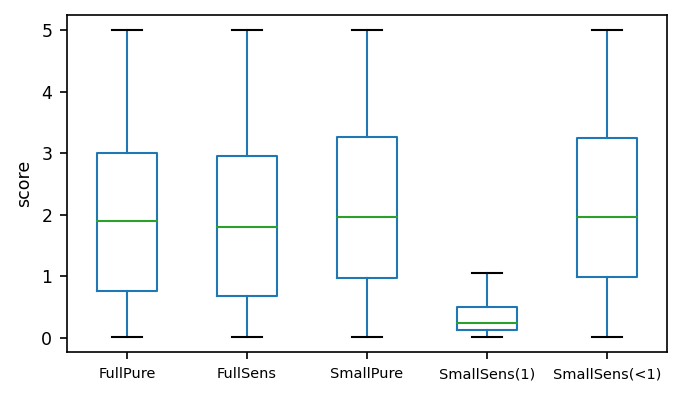

In [268]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
df.boxplot(column='score', by='type', ax=ax, grid=False, showfliers=False, fontsize='small', figsize=(6, 3))
fig.suptitle('')
plt.xlabel('')
plt.ylabel('score', fontsize='small')
plt.xticks(fontsize='x-small')
plt.title('')

# plt.savefig('boxone.png', bbox_inches='tight', dpi=200)

### Stake and difficulty breakdown

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=150, sharex=True)
# fig.tight_layout(pad=3.0)

ind = np.arange(2)  # the x locations for the groups
width = 0.1       # the width of the bars

types = ['FullPure', 'FullSens', 'SmallPure', 'SmallSens(<1)']
stakes = [1, 5]
Ns = [[5, 6], [14, 15]]
Nlabels = ['easy', 'difficult']

for s in range(2):
    temp = []
    for t in range(len(types)):
        for n in range(len(Nlabels)):
            d_score = df[(df['type']==types[t]) & (df['N_hyp'].isin(Ns[n])) & (df['stake']==stakes[s])]['score']
            mean = d_score.mean()
            sem = d_score.sem()
            temp.append(mean)
            axs[s].bar(ind[n]+t*width, mean, width, yerr=sem, 
                       error_kw={'elinewidth': 0.5, 'capsize': 3, 'capthick': 0.3},
                       color=sns.color_palette("deep")[t], alpha=0.85, label=types[t])
    low = min(temp)
    high = max(temp)
    axs[s].set_ylim(low-0.1*(high-low),high+0.1*(high-low))
    axs[s].set_title("stakes = "+str(stakes[s]), fontsize='small')
    axs[s].set_ylabel('Score', fontsize='x-small')
    axs[s].set_xticks(ind+t*width/2)
    axs[s].set_xticklabels(Nlabels, fontsize='small')

    handles, labels = axs[n].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[s].legend(by_label.values(), by_label.keys(), fontsize='xx-small', loc='best')

# plt.savefig('overview.png', bbox_inches='tight', dpi=250)

### Speed

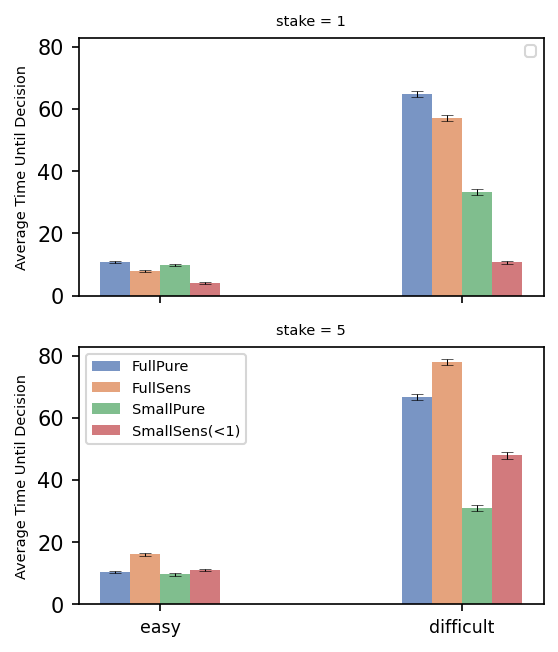

In [317]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=150, sharex=True, sharey=True)

ind = np.arange(2)  # the x locations for the groups
width = 0.1       # the width of the bars

types = ['FullPure', 'FullSens', 'SmallPure', 'SmallSens(<1)']
stakes = [1, 5]
Ns = [[5, 6], [14, 15]]
Nlabels = ['easy', 'difficult']

for s in range(2):
    for t in range(len(types)):
        for n in range(len(Nlabels)):
            d_speed = df[(df['type']==types[t]) & (df['N_hyp'].isin(Ns[n])) & (df['stake']==stakes[s])]['speed']
            axs[s].bar(ind[n]+t*width, d_speed.mean(), width, yerr=d_speed.sem(), 
                       error_kw={'elinewidth': 0.5, 'capsize': 3, 'capthick': 0.3},
                       color=sns.color_palette("deep")[t], alpha=0.75, label=types[t])
    axs[s].set_title('stake = '+str(stakes[s]), fontsize='x-small')
    axs[s].set_ylabel('Average Time Until Decision', fontsize='x-small')
    axs[s].set_xticks(ind+t*width/2)
    axs[s].set_xticklabels(Nlabels, fontsize='small')

    handles, labels = axs[n].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[s].legend(by_label.values(), by_label.keys(), fontsize='x-small')

plt.savefig('speed.png', bbox_inches='tight', dpi=250)

### Accuracy

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=150, sharex=True, sharey=True)

ind = np.arange(2)  # the x locations for the groups
width = 0.1       # the width of the bars

types = ['FullPure', 'FullSens', 'SmallPure', 'SmallSens(<1)']
stakes = [1, 5]
Ns = [[5, 6], [14, 15]]
Nlabels = ['easy', 'difficult']

for s in range(2):
    for t in range(len(types)):
        for n in range(len(Nlabels)):
            d_accuracy = df[(df['type']==types[t]) & (df['N_hyp'].isin(Ns[n])) & (df['stake']==stakes[s])]['accuracy']
            axs[s].bar(ind[n]+t*width, d_accuracy.mean(), width, yerr=d_accuracy.sem(), 
                       error_kw={'elinewidth': 0.5, 'capsize': 3, 'capthick': 0.3},
                       color=sns.color_palette("deep")[t], alpha=0.75, label=types[t])
    axs[s].set_title('stake = '+str(stakes[s]), fontsize='x-small')
    axs[s].set_ylabel('Average Accuracy', fontsize='x-small')
    axs[s].set_xticks(ind+t*width/2)
    axs[s].set_xticklabels(Nlabels, fontsize='small')

    handles, labels = axs[n].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[s].legend(by_label.values(), by_label.keys(), fontsize='x-small')

# plt.savefig('accuracy.png', bbox_inches='tight', dpi=250)

### Accuracy ~ Stake by Type

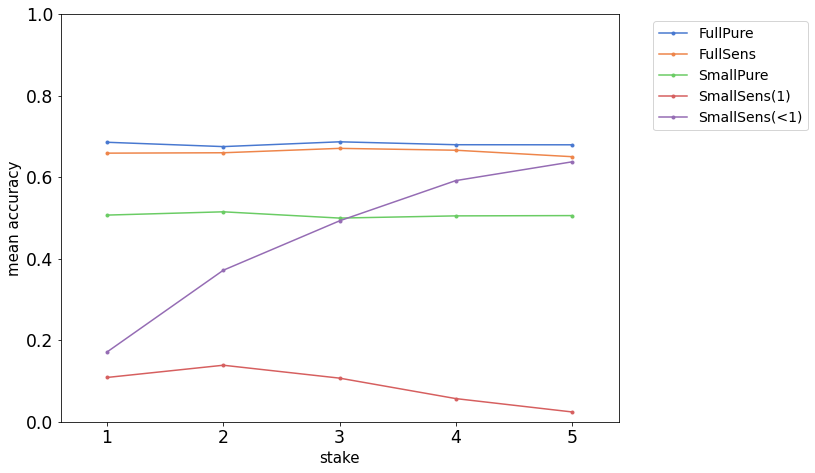

In [322]:
from statsmodels.graphics.factorplots import interaction_plot as intplt

d = df
fig=intplt(x=d.stake, trace=d.type, response=d.accuracy, 
          colors=sns.color_palette("muted", 5, as_cmap=False), legendloc=None)
fig.set_size_inches(10, 7.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim((0, 1))
# plt.legend().remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={"size":14})
plt.xlabel('stake', fontsize=15)
plt.ylabel('mean accuracy', fontsize=15)
plt.tick_params(labelsize='xx-large')
plt.rcParams['legend.title_fontsize'] = 'xx-large'

fig.savefig('stakeaccur.png', bbox_inches='tight', dpi=250)

## Other Stats

### Ordinary Least Square

In [315]:
d = df[(df['N_hyp'].isin([5, 6])) & (df['stake']==1) & (df['type'] != 'SmallSens(1)')]
m = ols("score ~ type", data=d).fit()
m.summary()

print(sm.stats.anova_lm(m, typ=2))
pair_t = m.t_test_pairwise('type')
pair_t.result_frame

              sum_sq      df          F        PR(>F)
type        2.656098     3.0  27.223759  1.870538e-17
Residual  158.446299  4872.0        NaN           NaN


,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
FullSens-FullPure,0.005407,0.007327,0.737933,4.605910e-01,-0.008958,0.019772,6.753162e-01,False
SmallPure-FullPure,-0.005769,0.007312,-0.788933,4.301897e-01,-0.020104,0.008567,6.753162e-01,False
SmallSens(<1)-FullPure,-0.053114,0.007305,-7.270986,4.136910e-13,-0.067435,-0.038793,2.068345e-12,True
SmallPure-FullSens,-0.011176,0.007305,-1.529960,1.260916e-01,-0.025497,0.003145,3.325822e-01,False
SmallSens(<1)-FullSens,-0.058521,0.007297,-8.019506,1.318886e-15,-0.072827,-0.044215,7.993606e-15,True
SmallSens(<1)-SmallPure,-0.047345,0.007282,-6.501368,8.756229e-11,-0.061622,-0.033068,3.502492e-10,True


### How often is the truth in the initial domain?

In [216]:
d = df
for t in df.type.unique():
    z = zip(d[d.type==t].truth, d[d.type==t].hyp)
    yes = 0
    for x in z:
        if x[0] in x[1]:
            yes += 1
    print(t, round(yes/(len(d[d.type==t])), 2))

FullPure 1.0
FullSens 1.0
SmallPure 0.85
SmallSens(<1) 0.81


### Frequency of true, false and no belief

FullPure
          1        -1      none
0  0.509370  0.035775  0.454855
1  0.499115  0.060177  0.440708
2  0.513201  0.036304  0.450495
3  0.505564  0.031797  0.462639
4  0.482871  0.057096  0.460033
FullSens
          1        -1      none
0  0.570715  0.108153  0.321131
1  0.511290  0.074194  0.414516
2  0.492308  0.059829  0.447863
3  0.474259  0.029641  0.496100
4  0.376130  0.012658  0.611212
SmallPure
          1        -1      none
0  0.578078  0.300300  0.121622
1  0.529517  0.334526  0.135957
2  0.518900  0.352234  0.128866
3  0.541667  0.331667  0.126667
4  0.561551  0.340641  0.097808
SmallSens(<1)


<ipython-input-217-51b9fb6f32ac>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([0]+list(data.columns))
<ipython-input-217-51b9fb6f32ac>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([0, 1] + list(data.index+2))
<ipython-input-217-51b9fb6f32ac>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([0]+list(data.columns))
<ipython-input-217-51b9fb6f32ac>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([0, 1] + list(data.index+2))
<ipython-input-217-51b9fb6f32ac>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([0]+list(data.columns))
<ipython-input-217-51b9fb6f32ac>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([0, 1] + list(data.index+2))
<ipython-input-217-

          1        -1      none
0  0.440351  0.540351  0.019298
1  0.517241  0.424138  0.058621
2  0.542994  0.326433  0.130573
3  0.551948  0.292208  0.155844
4  0.575908  0.186469  0.237624


Text(0, 0.5, 'rate')

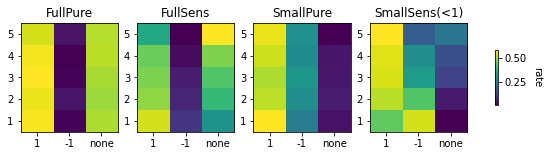

In [217]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(10, 2)

for i in range(4):
    t = types[i]
    print(t)
    correct = []
    incorrect = []
    none = []
    for j in range(1, 6):
        d = df[(df.type==t) & (df.stake==j) & (df.N_hyp==15)]
        correct.append((d.accuracy==1).sum(axis=0)/len(d))
        incorrect.append((d.accuracy==-1).sum(axis=0)/len(d))
        none.append((d.accuracy==0).sum(axis=0)/len(d))
    data = pd.DataFrame()
    data['1'] = correct
    data['-1'] = incorrect
    data['none'] = none
    print(data)
    im = axs[i].imshow(data, origin='lower', aspect='auto')
    axs[i].set_title(t)
    axs[i].set_xticklabels([0]+list(data.columns))
    axs[i].set_yticklabels([0, 1] + list(data.index+2))
cbar = fig.colorbar(im, ax=axs[:], shrink=0.5)
cbar.ax.set_ylabel('rate', rotation=270, labelpad=15)
# fig.savefig('v5/ratesbystake.png', bbox_inches='tight')